<h1 align="center">Credit Card Fraud Detection</h1>

---
### [Introduction](#intro)
### [Objective](#objective)
### [Exploratory Data Analysis (EDA)](#eda)
* [Understand - Structure & Variable Distribution](#understand)
* [Clean - Feature Engineer, Scale, Balance, & Outlier Handling](#clean)
* [Analyze Relationships - Correlation](#relate)

### [Modeling](#model)
* [Logistic Regression](#logistic)
* [Gradient Boosting Machine](#gbm)
* [Boosted Decision Tree](#bdt)
* [Extreme Gradient Boost](#xgb)
* [Random Forest](#forest)
* [Neural Network](#nn)

### [Conclusions](#outro)
### [Citations](#citations)
---

<a id="objective"></a>
## Objective
The primary goal of this notebook is to develop a highly performant model for detecting fraudulent credit card transactions that could be utilized by our client the credit card company. Along the way we will outline a generalized end to end process for completing a machine learning project from data load to model validation and insights derived from the ultimate solution. 

<a id="eda"></a>
## Exploratory Data Analysis (EDA)

First we need to explore the data set to **understand** our variables,
**clean** our dataset, and **analyze relationships** between variables. Ultimately EDA should allow us to answer the following questions from Daniel Bourke's article [A Gentle Introduction to Exploratory Data Analysis](https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184)[$^{5}$](#5):
* *What question(s) are you trying to solve (or prove wrong)?*
* *What kind of data do you have and how do you treat different types?*
* *What’s missing from the data and how do you deal with it?*
* *Where are the outliers and why should you care about them?*
* *How can you add, change or remove features to get more out of your data?*

While we won't explicitly answer these questions in this paper we will approach understanding, cleaning, and analyzing with them in mind. Before we begin it is important to remember that except for `Time` and `Amount` all explanatory variables are transformed due to privacy reasons. The explanatory variables were transformed through [prinicpal component analysis or PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and no further information can be provided regarding features `V1, V2, ..., V28`.

`Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature `Amount` is the transaction amount, this feature can be used for example-dependant cost-senstive learning. Finally the feature `Class` is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<a id="understand"></a>
### Understand - Structure & Variable Distribution
We start by reading in the credit card transaction data set CSV file as a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object and look a sample of some records using the [sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method. Then begin exploring using the [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to obtain descriptive statistics about each of the available variables.[$^{6}$](#6)

In [2]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
56129,47281.0,1.080323,-0.568533,0.860284,0.195172,-0.953803,-0.053286,-0.477530,0.003514,1.073925,-0.521574,-1.062200,0.963080,1.105630,-0.770277,-0.369284,-0.012479,-0.092109,-0.586077,0.618576,0.179646,-0.202402,-0.464615,-0.070139,-0.007966,0.205600,0.961009,-0.043872,0.026479,94.84,0
218844,141489.0,0.089633,0.829902,-0.002620,-0.744423,0.720417,-0.730484,0.993705,-0.154013,0.028944,-0.406706,-1.575042,-0.185444,-0.045858,0.106358,-0.333182,0.117090,-0.649863,-0.500361,0.177191,-0.023067,-0.306772,-0.713267,-0.008576,-0.666765,-0.402162,0.181668,0.244368,0.090174,5.37,0
241873,151230.0,-1.374534,1.879959,-1.104542,0.800434,1.327235,0.157034,0.563575,0.885196,-1.421497,-1.173713,-0.158082,-0.438041,-1.331485,-0.036886,-0.496699,0.038044,1.256897,1.326990,1.329790,-0.174188,0.058639,-0.145678,-0.641197,-0.344255,1.201938,-0.188552,-0.334881,-0.087079,8.12,0
197949,132249.0,-0.923248,-0.171543,1.166901,-1.611344,2.528496,4.240324,-0.336574,1.066135,0.174294,-0.755221,-0.202792,-0.212083,-0.159063,-0.379596,0.933383,0.415387,-0.838826,0.094538,-0.473833,0.269274,0.017449,-0.026653,-0.176672,0.707516,0.296844,0.289379,-0.133777,-0.153721,44.03,0
240311,150548.0,-0.393459,1.089048,0.151635,-1.048475,1.288228,-0.709886,1.224194,-0.134510,-0.384055,-1.387316,-0.976776,-0.274990,-0.037525,-0.984454,-0.518996,0.534591,0.136586,-0.163205,-0.524573,-0.116183,-0.300031,-0.889901,-0.126818,0.375989,-0.168867,0.074622,0.051963,0.157111,1.98,0


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The data set consists of `284807` observations of `31` variables, `30` explanatory and `1` response. Our data set does not contain any missing values making [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) irrelevant. It should be noted that "the problem of missing data is relatively common in almost all research and can have a significant effect on the conclusions that can be drawn from the data." [$^{7}$](#7) Various imputation methods can be taken when less than 30% of observations are missing at random, however, for scenarios where more than 30% of observations are missing or observations are not missing at random it is best practice to remove the variable(s) in question. 

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Looking at the response variable `Class` we see the dataset is very imbalanced with only **0.17%** of observations result in a fraudulent transactions. This is to be expected, if fraudulent transactions were very common credit card companies would lose money and likely cease to operate. The topic of balancing will be explored the next section but lets continue reviewing the structure and distribution of our available variables.

In [6]:
df['Class'].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

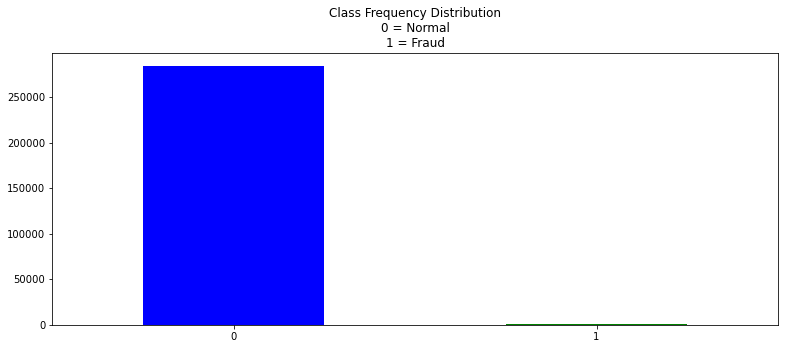

In [7]:
df['Class'].value_counts(sort=False).plot.bar(
    title="Class Frequency Distribution\n0 = Normal\n1 = Fraud", 
    color=['blue','green'],
    rot=0,
    figsize=(13,5)
);

`Time` appears to be cyclical with periods every approximately `86000` seconds (24 hours). We will execute simple feature engineering to break out the various time components, e.g. hour, min, second. If the data contained at least 2 weeks worth of observations we could possibly extract the day of week component as there is often a weekly seasonality in transaction or sales data.[$^{30}$](#30) We will subsequently scale the new time component features to align with the PCA variables.  

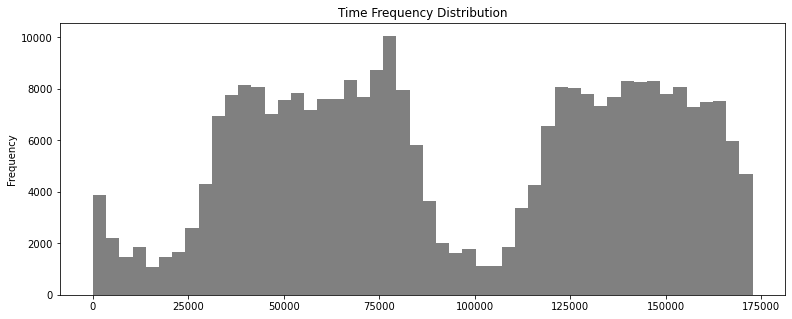

In [8]:
df['Time'].plot.hist(
    title="Time Frequency Distribution",
    bins=50, 
    color='grey',
    figsize=(13,5)
);

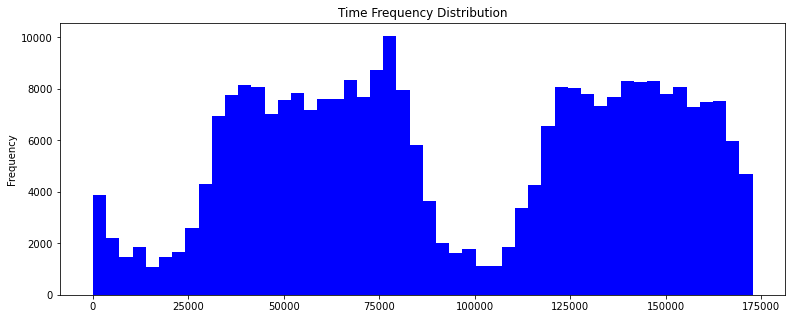

In [9]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df['Time'].plot.hist(
    title="Time Frequency Distribution",
    bins=50,
    color='blue',  # Change the color here
    figsize=(13, 5)
)
plt.show()


`Amount` is a highly skewed variable with maximum observed value of `25,691.16` however most transactions averaging at only `88`. Again because of the wide distribution of values we will scale the values down and align with the PCA variables. We should also note that `Amount` does not have any unit associated with it. Given the fact that the data was sourced in Europe which has many currencies and the fact that we will be scaling the variable later we will leave the numeric value unitless.

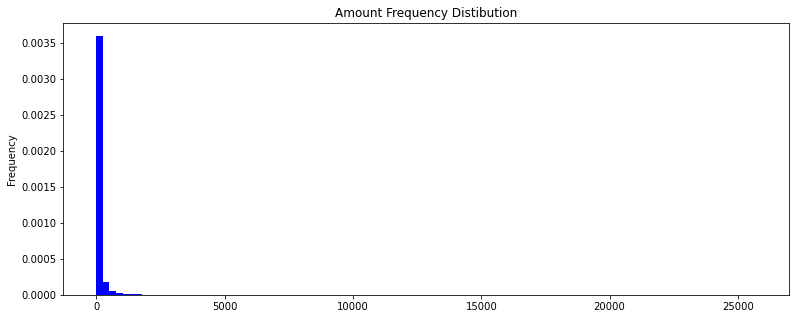

In [10]:
df['Amount'].plot.hist(
    title="Amount Frequency Distibution",
    bins=100,
    color='blue',
    figsize=(13,5),
    density=True
);

All of our PCA variables,`V1, V2, ..., V28`, as mentioned before have been transformed.

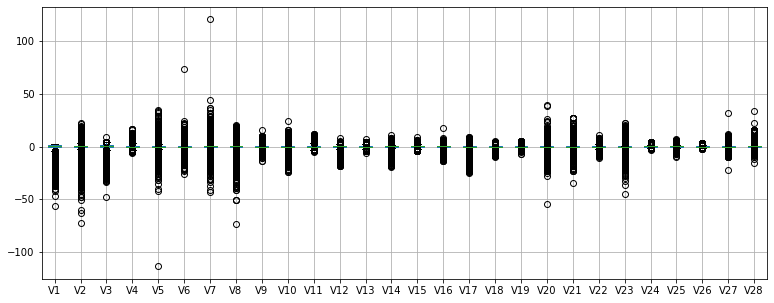

In [11]:
df.drop(['Time','Amount','Class'],axis=1).boxplot(figsize=(13,5));

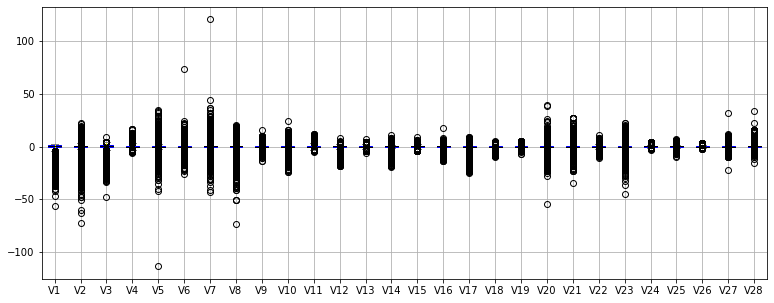

In [12]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df.drop(['Time','Amount','Class'], axis=1).boxplot(
    figsize=(13, 5),
    color=dict(boxes='blue', whiskers='yellow', medians='black', caps='gray')  # Change the color here
)
plt.show()


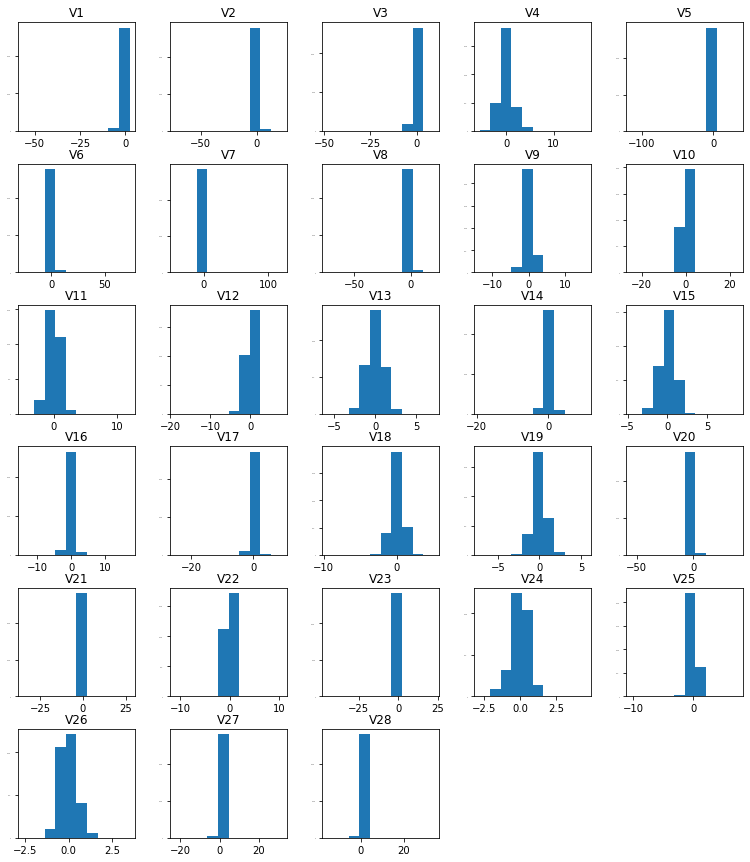

In [13]:
df.drop(['Time','Amount','Class'],axis=1).hist(
    figsize=(13,15), 
    ylabelsize=False,
    grid=False
);

Looking closer we can see some variety in the distributions even though all the PCA variables have mean values of `0`. Distributions of variables `V4`, `V12`, and `V28` are shown below. `V4` shows a slightly right skewed, `V12` appears to be left skewed, and `V28` shows a very narrow distribution. We will look at these distributions with respect to our target variable `Class` later as it might be that the normal transactions follow a normal distribution and that the fraudulent transactions are what are skewing these plots.

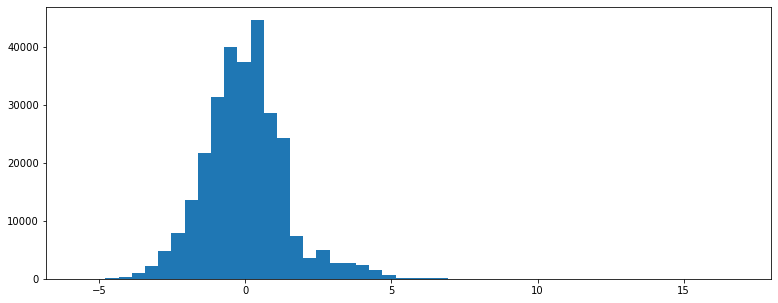

In [14]:
df.V4.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

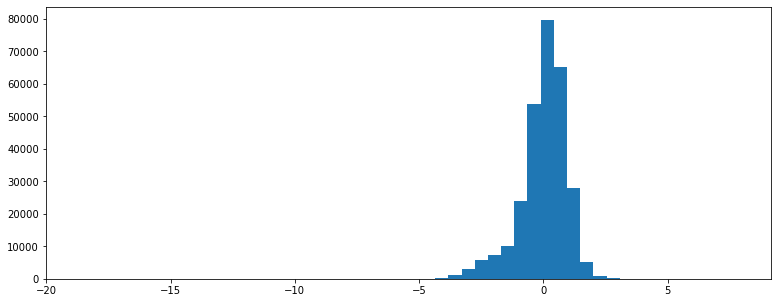

In [15]:
df.V12.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

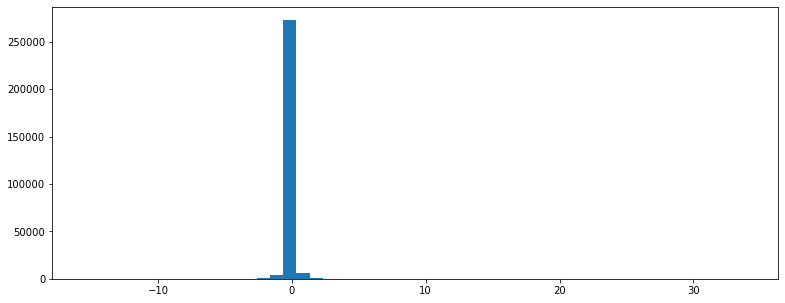

In [16]:
df.V28.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

Before we proceed to clean our data set we will make a copy to compare with later. 

In [17]:
original = df.copy()

<a id="clean"></a>
### Clean - Feature Engineer, Scale, Balance, & Outlier Handling


Now we will revisit the variables `Time` and `Amount` to extract and scale them. [Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) is a set of methods used to normalize the range of explanatory variables.[$^{8}$](#8) The primary methods are: 
* [rescaling (min-max normalization)](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
* [mean normalization](https://en.wikipedia.org/wiki/Feature_scaling#Mean_normalization)
* [standardization (z-score normalization)](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization))
* [scaling to unit length](https://en.wikipedia.org/wiki/Feature_scaling#Scaling_to_unit_length)

Baijayanta Roy does a great job outlining several reasons why scaling is desirable in support of some machine learning algorithms. In [All about Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35) Roy notes that "Neural network gradient descent converge much faster with feature scaling than without it."

He continues, "Scaling is critical while performing **Principal Component Analysis (PCA)**. PCA tries to get the features with maximum variance, and the variance is high for high magnitude features and skews the PCA towards high magnitude features." [$^{9}$](#9)

Given the use of PCA in our dataset it seems highly advisable to use feature scaling for the `Time` and `Amount` variables. `Time` doesn't have any substantial outliers, however `Amount` is heavily right skewed resulting in a large number of outliers as seen in the [Matplotlib](https://matplotlib.org) boxplots below.[$^{10}$](#10) 

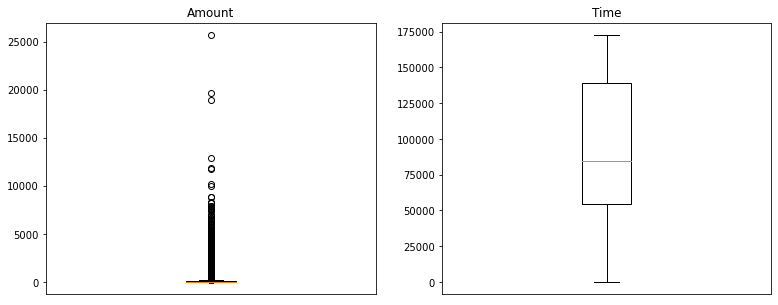

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
axes[0].get_xaxis().set_visible(False)
axes[0].set_title('Amount')
axes[0].boxplot(df['Amount'])
axes[1].get_xaxis().set_visible(False)
axes[1].set_title('Time')
axes[1].boxplot(df['Time']);

Feature scaling particularly benefits machine learning models because it allows for improved gradient descent requiring less iterations to arrive at minimum cost $ J(\theta)$. There are a number of great resources around cost functions, $ J(\theta)$, including [Andrew Ng's Machine Learning](https://www.coursera.org/learn/machine-learning) course on Coursera. "Put simply, a cost function is a measure of how wrong the model is in terms of its ability to estimate the relationship between X and y."[$^{38}$](#38) Gradient descent is an optimization algorithm that aims at finding the local or global minima of the aforementioned cost function. 

<img src="https://static.commonlounge.com/fp/600w/HUvkPMB4OlJqQU7LzAZXdWzgw1556694254_kc" />

Before we scale however we need to take a moment to work through some feature engineering to extract the various time components (e.g. hour, minute, second) from the `Time` variable

In [19]:
df['hour'] = pd.to_timedelta(df['Time'], unit='s').dt.components.hours
df['minute'] = pd.to_timedelta(df['Time'], unit='s').dt.components.minutes
df['second'] = pd.to_timedelta(df['Time'], unit='s').dt.components.seconds

We will be using RobustScaler from the [Scikit-learn](https://scikit-learn.org/stable/index.html) package because it is as the name suggests robust to outliers. According to the [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) documentation, 

"This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method."[$^{11}$](#11)

In [20]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
hours_scaled = scaler.fit_transform(df['hour'].values.reshape(-1,1))
minutes_scaled = scaler.fit_transform(df['minute'].values.reshape(-1,1))
seconds_scaled = scaler.fit_transform(df['second'].values.reshape(-1,1))
amount_scaled = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.drop(['Time','Amount','hour','minute','second'], axis=1, inplace=True)
df.insert(0, 'hour_scaled', hours_scaled)
df.insert(1, 'minute_scaled', minutes_scaled)
df.insert(2, 'second_scaled', seconds_scaled)
df.insert(3, 'amount_scaled', amount_scaled)

Next we will look to balance the dataset to avoid overfitting in our downstream models. "Many real world classification problems are represented by highly unbalanced data sets, in which, the number of samples from one class is much smaller than from another. This is known as class imbalance problem and is often reported as an obstacle to constructing a model that can successfully discriminate the minority samples from the majority samples."[$^{12}$](#12)

To address the class imbalance problem we will utilize a combination of Random Under Sampling and SMOTE for over sampling. Random Under Sampling, a technique where we identify _n_, the minimum observations between our response variable classes, then take a random sample of size _n_ from the class with more observations to have a resulting 50/50 ratio. It should be noted that this process can result in loss of information but depending on the use case may have good results.[$^{13}$](#13) 

<img src=https://miro.medium.com/max/3348/1*P93SeDGPGw0MhwvCcvVcXA.png />

SMOTE, which stands for Synthetic Minority Over-sampling Technique, over-samples the minority class by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the _k_ minority class nearest neighbors. Synthetic samples are generated by taking the difference between the sample under consideration and its nearest neighbor, multiplying the difference by a random number between 0 and 1 then adding it to the sample under consideration. This technique ultimately forces the decision region of the minority class to become more general.[$^{25}$](#25)  

<img src=https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png />

We happen to have **492 Fraud** transactions and **284315 Normal** transactions so we will use Random Under Sampling to sample 49200 observations from the normal subset and SMOTE to generate 49200 Fraud observations. 

In [21]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [22]:
from imblearn.over_sampling import SMOTE
seed = 1618 # random state for reproducability 

fraud = df[df['Class']==1]
normal = df[df['Class']==0].sample(len(fraud)*100, random_state=seed)
df = pd.concat([normal,fraud])
sm = SMOTE(random_state=seed)
x = df.drop(['Class'], axis = 1)
y = df["Class"]
x_res, y_res = sm.fit_resample(x, y)
df = x_res
df['Class'] = y_res
df = df.sample(frac=1, random_state=seed)

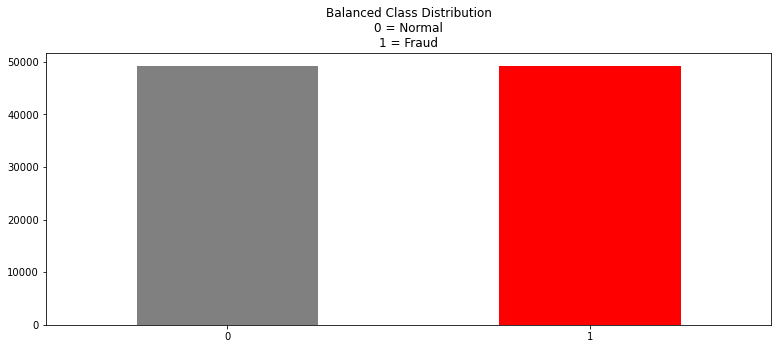

In [23]:
df['Class'].value_counts(sort=False).plot.bar(
    title="Balanced Class Distribution\n0 = Normal\n1 = Fraud", 
    color=['grey','red'],
    rot=0,
    figsize=(13,5)
);

Next up in the clean phase is outlier handling. Outliers can come in a variety of forms, the most common are **Global Anomalies** a.k.a. point anomalies, **Contextual Anomalies** a.k.a. conditional anomalies, and **Collective Anomalies**. These outliers are often the result of data entry errors, measurement errors, or are simply natural outliers.[$^{14}$](#14)

Jim Frost in [Guidelines for Removing and Handling Outliers in Data](https://statisticsbyjim.com/basics/remove-outliers/) notes, "Sometimes it’s best to keep outliers in your data. They can capture valuable information that is part of your study area."[$^{15}$](#15) Others such as Tamás Nyitrai and Miklós Virág in [The effects of handling outliers on the performance of bankruptcy prediction models](https://doi.org/10.1016/j.seps.2018.08.004) indicate that "There seems to be consensus in the literature on the necessity of handling outliers, at the same time, it is not clear how to define extreme values to be handled in order to maximize the predictive power of models."[$^{16}$](#16)

Given the seemingly conflicting ideas around outlier handling we will opt to look at very extreme values and use imputation to replace the removed values which should provide us with overall improvements to our model accuracy metrics. While there are a number of different outlier detection techniques we will be using NumPy[$^{28}$](#28) and the IQR method, specifically targeting the most extreme values (3X IQR) applying a univariate approach. For imputation we will leverage [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) from Scikit-learn to replace the removed values. 

IterativeImputer uses "\[a\] strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion", which was inspired by the R MICE package (Multivariate Imputation by Chained Equations). This multivariate approach for imputation typically results in a significantly lower MSE when compared to simple univariate mean imputation. 

For a summary of several outlier detection techniques including Z-score method, Winsorization method, Isolation Forest, and more see Naresh Bhat's [Outlier!!! The Silent Killer](https://www.kaggle.com/nareshbhat/outlier-the-silent-killer) notebook on Kaggle.[$^{17}$](#17) 

In [24]:
import numpy as np

outliers = {}
for col in df.drop(['hour_scaled','minute_scaled','second_scaled','Class'], axis=1).columns:
    q25 = np.percentile(df[col].loc[df['Class'] == 1].values, 25) 
    q75 = np.percentile(df[col].loc[df['Class'] == 1].values, 75)
    iqr = q75 - q25
    upper = q75 + (iqr * 3)
    lower = q25 - (iqr * 3)
    outliers[col] = [x for x in df[col].loc[df['Class'] == 1].values 
                if x < lower or x > upper]
    df[col].replace(df[(df[col] > upper) | (df[col] < lower)].index, np.nan, inplace=True)

In [25]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=seed)
imp_arr = imputer.fit_transform(df)
df = pd.DataFrame(imp_arr, columns=df.columns)

Below we compare boxplots from our original dataframe and the now cleaned dataframe. Notice the y-axis scale is significantly reduced in our cleaned dataframe and the boxes are actually visible for most of our variables.

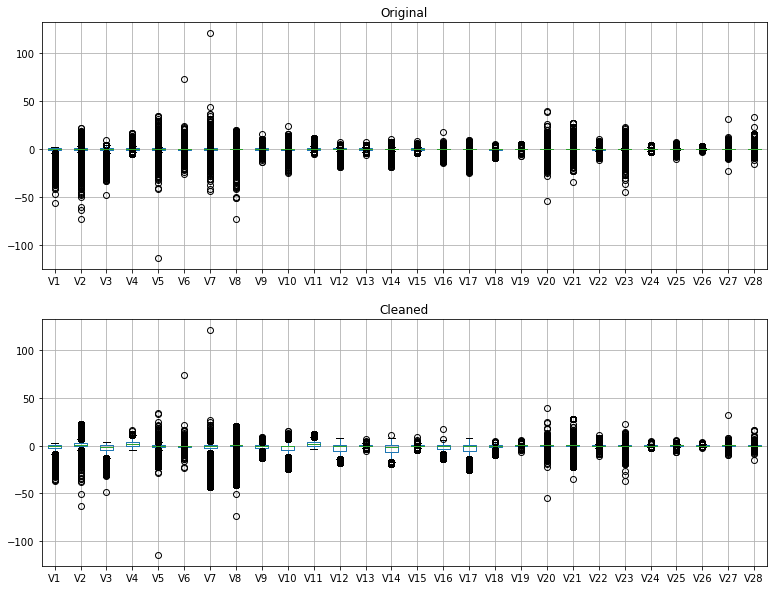

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10));
axes[0].set_title('Original');
original.drop(['Time','Amount','Class'],axis=1).boxplot(figsize=(13,5), ax=axes[0]);
axes[1].set_title('Cleaned');
df.drop(['hour_scaled',
         'minute_scaled',
         'second_scaled',
         'amount_scaled',
         'Class'],axis=1).boxplot(figsize=(13,5), ax=axes[1]);

<a id="relate"></a>
### Analyze Relationships - Correlation

We continue by looking at the correlation across our explanatory variables. "Correlation analysis is a statistical method used to evaluate the strength of relationship between two quantitative variables. A high correlation means that two or more variables have a strong relationship with each other, while a weak correlation means that the variables are hardly related."[$^{18}$](#18) 

We will be using the Pearson correlation coefficient (PCC) as our statistic for measuring the relationships between our variables. PCC, also referred to as Pearson's _r_, is a statistic that measures the linear correlation between two variables _X_ and _Y_ and has a value between -1 and +1. Variables with a positive correlation (PCC > 0) behave in a manner in which the increase in one of the variables results in an increase in the other. The opposite can be said of variables with a negative correlation (PCC < 0), an increase in one of the variables results in a decrease in the other. Variables with PCC close to 0 have no linear correlation.[$^{19}$](#19)

Below is a heatmap generated using the [Seaborn](https://seaborn.pydata.org/index.html) data visualization library and reflecting the Pearson correlation coefficient between all pairs of variables.[$^{20}$](#20) <span style="color:darkblue"> **Dark blue**</span> indicating strong positive correlation (PCC $\approx$ +1) and <span style="color:darkred"> **dark red**</span> indicating strong negative correlation (PCC $\approx$ -1).

In [28]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.10.0)


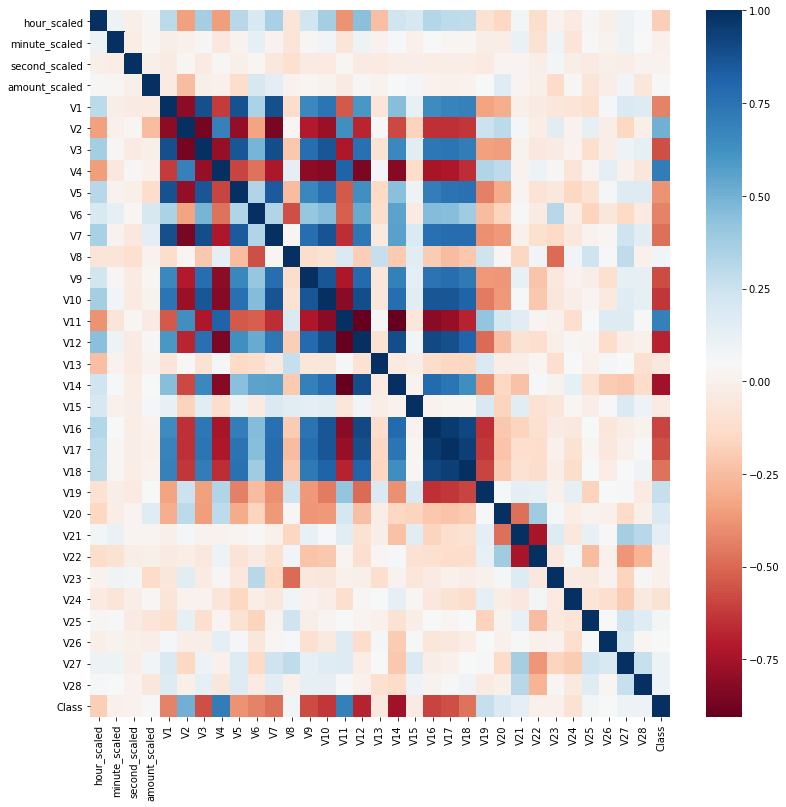

In [30]:
import seaborn as sns

corr = df.corr()
fig = plt.figure(figsize=(13,13))
sns.heatmap(
    corr, 
    cmap="RdBu",
    xticklabels=corr.columns,
    yticklabels=corr.columns
);

Listing the PCC for all explanatory variables with respect to our dependent variable `Class` in ascending order

In [31]:
print(corr['Class'].sort_values())

V14             -0.758997
V12             -0.682848
V10             -0.636053
V16             -0.597100
V9              -0.574197
V17             -0.564852
V3              -0.563319
V7              -0.478326
V18             -0.471480
V1              -0.425659
V6              -0.423333
V5              -0.382766
hour_scaled     -0.184260
V24             -0.092008
V13             -0.056718
V15             -0.030294
minute_scaled   -0.003443
V22             -0.000122
V23              0.000481
second_scaled    0.002549
amount_scaled    0.040536
V26              0.052131
V25              0.070954
V8               0.084352
V27              0.093551
V28              0.106097
V21              0.141852
V20              0.187488
V19              0.277831
V2               0.503695
V11              0.699367
V4               0.714225
Class            1.000000
Name: Class, dtype: float64


Using the statsmodels[$^{32}$](#32) library to do a basic logistic regression we can see all the variables are significant with _p-value_ < _0.05_ and the model has a resulting **_AIC_ = 46.95** which we will use as a baseline for comparing against a simplified logisitic regression model later.

In [32]:
import statsmodels.api as sm
sm_model = sm.Logit(df['Class'],df.drop(['Class'], axis=1)).fit(disp=0)
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                98400
Model:                          Logit   Df Residuals:                    98368
Method:                           MLE   Df Model:                           31
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.6808
Time:                        06:41:02   Log-Likelihood:                -21773.
converged:                       True   LL-Null:                       -68206.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
hour_scaled       0.4349      0.023     18.552      0.000       0.389       0.481
minute_scaled     0.0526      0.022      2.399      0.016       0.010       0.096
second_scaled    -0.2050      0.022     -9.518      0.000      -0.247      -0.163
amount_scaled    -1.9882      0.030    -67.242      0.000      -2.046      -1.930
V1               -1.3572      0.042    -32.045      0.000      -1.440      -1.274
V2               -2.3742      0.091    -25.980      0.000      -2.553      -2.195
V3               -2.2026      0.104    -21.109      0.000      -2.407      -1.998
V4                1.8789      0.062     30.340      0.000       1.757       2.000
V5               -2.6088      0.062    -42.178      0.000      -2.730      -2.488
V6                0.8185      0.044     18.759      0.000       0.733       0.904
V7                1.1245      0.182      6.195      0.000       0.769       1.480
V8               -0.7717      0.049    -15.715      0.000      -0.868      -0.675
V9               -1.1036      0.074    -14.942      0.000      -1.248      -0.959
V10              -2.7602      0.166    -16.602      0.000      -3.086      -2.434
V11               1.7170      0.120     14.352      0.000       1.483       1.952
V12              -3.0024      0.216    -13.884      0.000      -3.426      -2.579
V13              -0.0244      0.013     -1.933      0.053      -0.049       0.000
V14              -2.9164      0.227    -12.856      0.000      -3.361      -2.472
V15               0.0768      0.015      5.102      0.000       0.047       0.106
V16              -2.2703      0.206    -11.011      0.000      -2.674      -1.866
V17              -4.0088      0.370    -10.826      0.000      -4.735      -3.283
V18              -1.2392      0.141     -8.812      0.000      -1.515      -0.964
V19               0.0202      0.052      0.390      0.697      -0.081       0.122
V20               2.5835      0.031     82.742      0.000       2.522       2.645
V21               1.1389      0.029     38.995      0.000       1.082       1.196
V22              -0.5496      0.022    -24.492      0.000      -0.594      -0.506
V23              -2.2827      0.047    -48.210      0.000      -2.376      -2.190
V24               0.1062      0.023      4.597      0.000       0.061       0.152
V25              -0.7270      0.034    -21.483      0.000      -0.793      -0.661
V26              -0.3716      0.029    -12.868      0.000      -0.428      -0.315
V27               1.4207      0.056     25.471      0.000       1.311       1.530
V28               1.4923      0.073     20.571      0.000       1.350       1.634
=================================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We will create a simple function for investigating goodness of fit using traditional AIC statistic. This statistic is a small component for comparing models we will discuss others in the modeling section. 

In [33]:
def AIC(true,pred,cols):
    resid = true - pred
    sse = sum(resid**2)
    k = len(cols)
    AIC = 2*k - 2*np.log(sse)
    
    return AIC

In [34]:
y_val_base = sm_model.predict(df.drop(['Class'],axis=1))
AIC_base = AIC(df['Class'],y_val_base,df.drop(['Class'],axis=1).columns)
print('Baseline AIC: ', AIC_base)

Baseline AIC:  46.95134448365124


The variables with the lowest correlations (+/- 0.1) can be removed as they will not provide any valuable information in our models because the distributions are too similar between the two classes. 

In [35]:
irr_vars = list(corr['Class'][abs(round(corr['Class'].sort_values(),2))<=0.10].index)
df.drop(irr_vars, axis=1, inplace=True)

The variables with largest negative correlations are `V14, V12, V10, V16, V3, V9` and the ones with the largest positive correlations are `V4, V11, V2, V19`. We will look at each of these next to understand how the transactions compare across the two classes. 

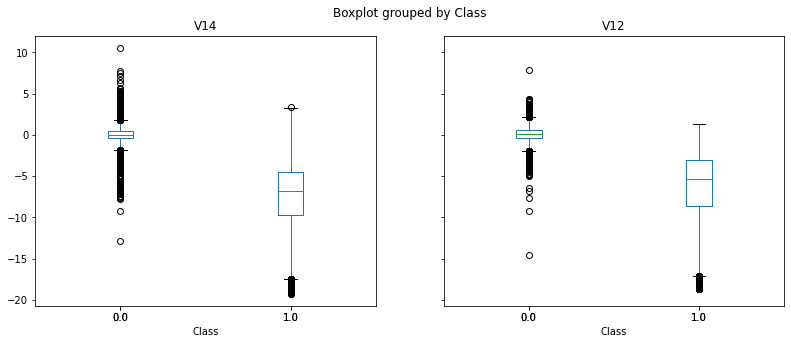

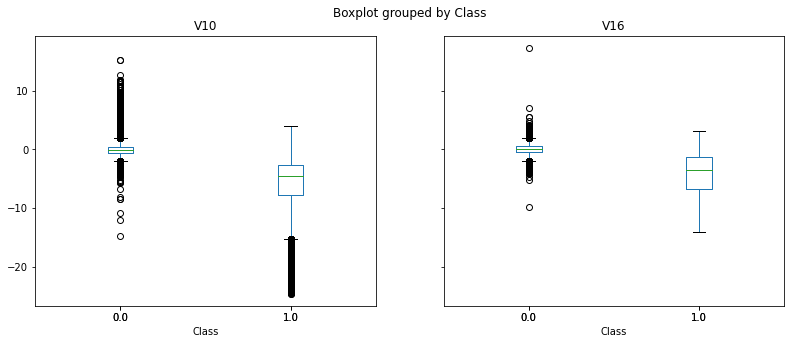

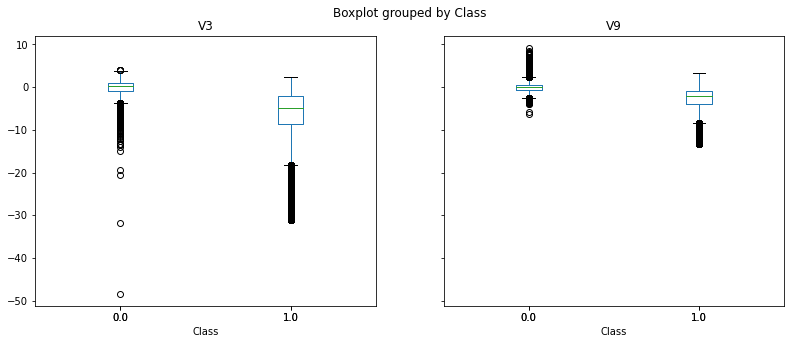

In [36]:
df.boxplot(['V14','V12'], by='Class', figsize=(13,5), grid=False)
df.boxplot(['V10','V16'], by='Class', figsize=(13,5), grid=False)
df.boxplot(['V3','V9'], by='Class', figsize=(13,5), grid=False);

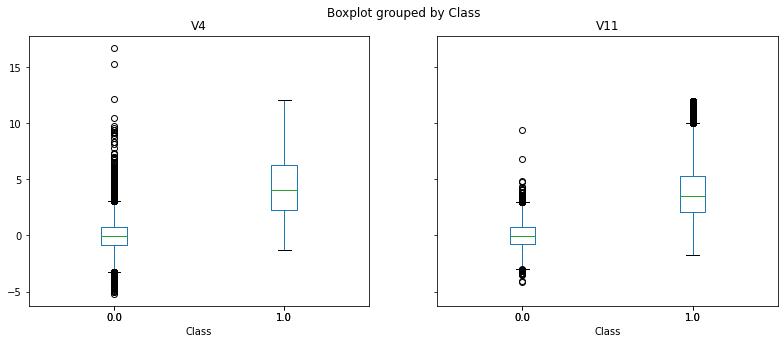

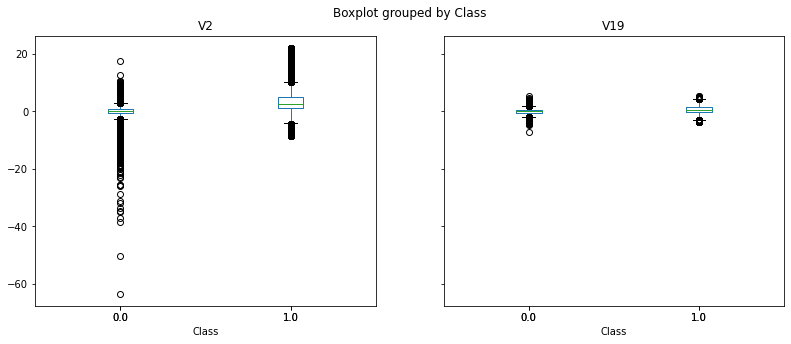

In [37]:
df.boxplot(['V4', 'V11'], by='Class', figsize=(13,5), grid=False)
df.boxplot(['V2', 'V19'], by='Class', figsize=(13,5), grid=False);

Another way to compare the distributions of the remaining variables with respect to `Class` is by using histogram plots with kernel density estimates (KDE) overlay. We have color coded normal transactions in <span style="color:gray"> **gray** </span> and fraud transactions in <span style="color:red"> **red** </span> as we have done earlier in this notebook and as indicated in the legend for each plot. <a id="kde"></a>

AttributeError: module 'seaborn' has no attribute 'histplot'

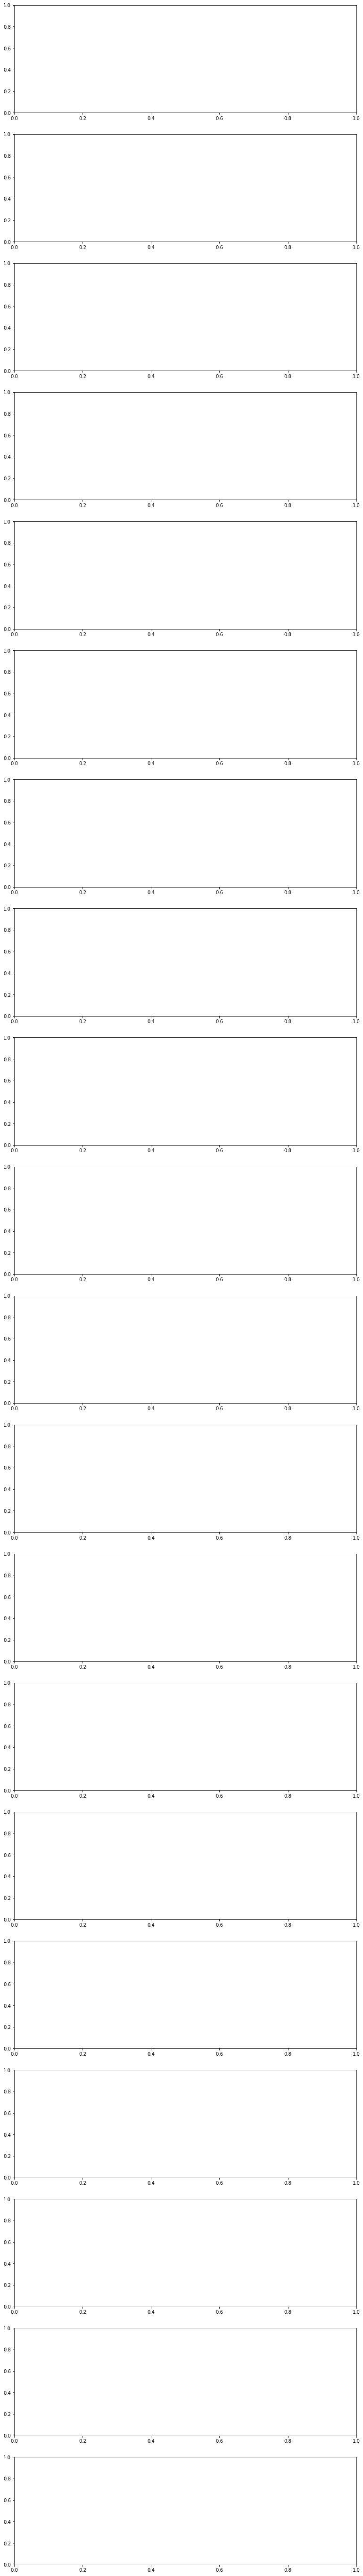

In [38]:
exp_vars = df.drop(['Class'], axis=1).columns
fig, axes = plt.subplots(nrows=len(exp_vars), ncols=1, figsize=(13,len(exp_vars)*5));
for var in exp_vars:
    sns.histplot(
        data=df, 
        x=var, 
        bins=50, 
        kde=True, 
        hue='Class', 
        palette=['grey','red'],
        ax=axes[list(exp_vars).index(var)]
    );

AttributeError: module 'seaborn' has no attribute 'histplot'

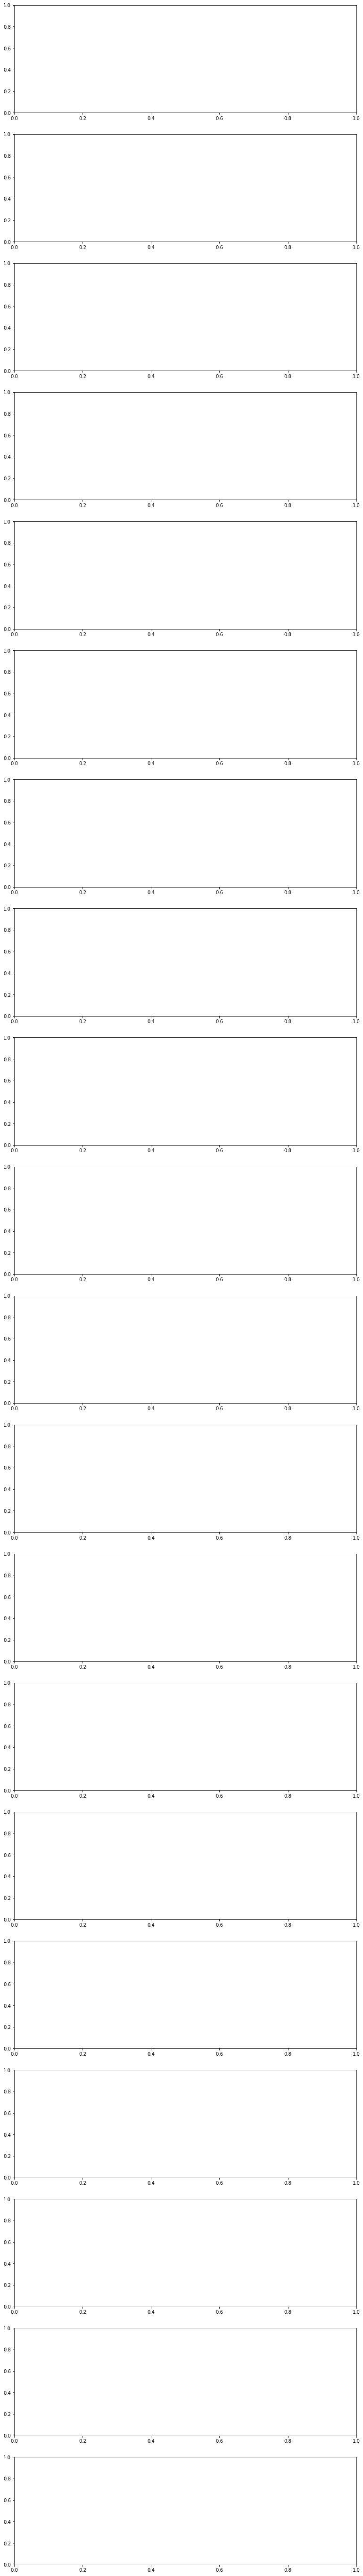

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

exp_vars = df.drop(['Class'], axis=1).columns
fig, axes = plt.subplots(nrows=len(exp_vars), ncols=1, figsize=(13, len(exp_vars)*5))
for var in exp_vars:
    sns.histplot(
        data=df, 
        x=var, 
        bins=50, 
        kde=True, 
        hue='Class', 
        palette=['grey','red'],
        ax=axes[list(exp_vars).index(var)]
    )
plt.tight_layout()
plt.show()


<a id="model"></a>
## Modeling

Before we begin generating various predictive models from our Binary Classification problem it is important to discuss how we can assess model performance. [Amazon Machine Learning Developer Guide](https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html) indicates "typical metrics are accuracy (ACC), precision, recall, false positive rate, and F1-measure". [$^{21}$](#21)

These evaluation metrics are calculated from four basic combinations of actual data cateogry and assigned category:
* **True Positive (TP)** - correct positive assignment
* **True Negative (TN)** - correct negative assignment
* **False Positive (FP)**  \[Type I Error\] - incorrect positive assignment   
* **False Negative (FN)**  \[Type II Error\] - incorrect negative assignment    

A confusion matrix, also known as an error matrix, is a 2x2 table that reflects these assignments. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class (or vice versa)[$^{29}$](#29)
<p></p>

<img src="https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg" />


Accuracy (ACC) is the fraction of correct assignment (TP + TN)/(TP + TN + FP + FN), precision is the fraction of TP/(TP + FP), recall a.k.a. sensitivity is the fraction TP/(TP + FN), false positive rate is FP/(TN + FP), and finally F1-measure or F1-score is the "harmonic mean of precision and recall"[$^{22}$](#22)[$^{23}$](#23) 

<p><center>$\normalsize F_1= \frac{2}{recall^{-1} + precision^{-1}} = 2  \frac{precision * recall}{precision + recall}=\frac{TP}{TP + \frac{1}{2}(FP + FN)}$</center></p>

Depending on the use case one might be more interested in a model that performs well for a specific metric or subset of metrics over others. For credit card fraud it is important that we have both high precision and high recall. F1-measure is often considered to be the most relevant measure in fraud detection due to its combination of of precision and recall into a single metric.[$^{24}$](#24) Now that we know we need to evaluate our models to favor high recall or high sensitivity we need to split our data into train and test sets.

In [40]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, shuffle=True, random_state=seed)
x_train = train_df.drop(['Class'], axis = 1)
y_train = train_df["Class"]
x_test = test_df.drop(['Class'], axis = 1)
y_test = test_df["Class"]

### Logisitic Regression
<a id="logistic"></a>

Logistic model uses the logistic or inverse logit function to model a binary or dichotomous variable. Similar to linear regression, logistic regression fits the data to a line however unlike linear regression the line is not straight but rather an S shaped curved called **Sigmoid**. The S shaped curve is bound on the Y axis between 0 and 1 which fits our goal of binary classification. The sigmoid function (shown below) provides us with a probability of an observation belonging to one of the two classes. [$^{26}$](#26) [$^{27}$](#27)

<p><center>$\normalsize sigmoid(x)= \frac{1}{1+e^{-x}} = \frac{e^{x}}{e^{x}+1}$</center></p>
<p></p>
Representative plots for a linear regression and logistic regression can be seen below.
<p><img src="https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg" /></p>

**NOTE:** _We will be using a random search approach for selecting optimal model hyperparameters for all models shown below. Additionally, we will be looking at the delta (difference) of F1 scores between train and test sets. If F1 delta is > 0 then we can conclude the model does not overfit and can generalize for unseen observations. If F1 delta is < 0 then we would say the model is overfitting and does not generalize for unseen observations. For more details on hyperparameter tuning please refer to "Hypterparameter Tuning for Machine Learning Models" by Jeremy jordan and "Random Search for Hyper-Parameter Optimization" by James Bergstra et al. [$^{33}$](#33)[$^{34}$](#34) For more details on overfitting please refer to "The Problem of Overfitting" by Douglas M. Hawkins._ [$^{31}$](#31)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
import time

params_lr = {
    'penalty' : ['l1', 'l2'],
    'C' : sp_randFloat(0, 4),
    'solver' : ['lbfgs',],
    'random_state': [seed]
}

lr = RandomizedSearchCV(
    LogisticRegression(), 
    param_distributions=params_lr, 
    cv=5, 
    n_iter=5, 
    n_jobs=-1 
)

t1 = time.time()
best_lr = lr.fit(x_train, y_train)
t2 = time.time()
y_pred_lr = best_lr.predict(x_test)
t3 = time.time()
y_val_lr = best_lr.predict(x_train)
t_fit_lr = t2 - t1
t_pred_lr = t3 - t2

print('The best parameters across ALL searched params:\n', best_lr.best_params_)

The best parameters across ALL searched params:
 {'C': 0.7793476061013513, 'penalty': 'l2', 'random_state': 1618, 'solver': 'lbfgs'}


In [42]:
f1_test_lr = f1_score(y_test, y_pred_lr)
f1_train_lr = f1_score(y_train, y_val_lr)
f1_delta_lr = round(f1_test_lr-f1_train_lr,5)
print('F1 Score Delta: {}'.format(f1_delta_lr))

F1 Score Delta: 0.00312


In [43]:
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    0.91284   0.97698   0.94382      9819
       Fraud    0.97536   0.90711   0.94000      9861

    accuracy                        0.94197     19680
   macro avg    0.94410   0.94205   0.94191     19680
weighted avg    0.94416   0.94197   0.94190     19680



In [44]:
AIC_lr = AIC(y_test,y_pred_lr,x_train.columns)
print('LR AIC: ', AIC_lr)

LR AIC:  25.91892721956809


Using the same statsmodels approach as we did for the basic logistic regression in the [analyze relationships - correlation](#relate) section in the two cells below the resulting **_AIC_ = _25.1_**. This AIC value is very similar to that of the AIC from the Scikit-learn logisitc regression model above which had the value of **_25.9_**. This demonstrates that both the statsmodels library and the Scikit-learn library have similiar outcomes and that our efforts for feature reduction through the correlation analysis was the correct approach as these models fit our data better than the basic logisitic regression. 

In [45]:
sm_model = sm.Logit(y_train, x_train).fit(disp=0)
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                78720
Model:                          Logit   Df Residuals:                    78700
Method:                           MLE   Df Model:                           19
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.5265
Time:                        06:43:04   Log-Likelihood:                -25834.
converged:                       True   LL-Null:                       -54565.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
hour_scaled     0.5225      0.020     26.551      0.000       0.484       0.561
V1             -1.4609      0.021    -70.343      0.000      -1.502      -1.420
V2              1.4094      0.021     67.239      0.000       1.368       1.450
V3             -3.2777      0.045    -72.820      0.000      -3.366      -3.189
V4              2.1932      0.029     74.937      0.000       2.136       2.251
V5             -2.1650      0.032    -68.528      0.000      -2.227      -2.103
V6             -0.6943      0.013    -54.709      0.000      -0.719      -0.669
V7             -4.2813      0.061    -70.121      0.000      -4.401      -4.162
V9             -2.1469      0.033    -64.652      0.000      -2.212      -2.082
V10            -5.0815      0.072    -70.256      0.000      -5.223      -4.940
V11             3.5909      0.049     72.892      0.000       3.494       3.687
V12            -6.4003      0.087    -73.867      0.000      -6.570      -6.230
V14            -6.5961      0.090    -73.292      0.000      -6.773      -6.420
V16            -5.7561      0.081    -71.005      0.000      -5.915      -5.597
V17           -10.3268      0.146    -70.626      0.000     -10.613     -10.040
V18            -3.7993      0.056    -68.333      0.000      -3.908      -3.690
V19             1.1726      0.022     53.625      0.000       1.130       1.215
V20             0.7383      0.021     34.419      0.000       0.696       0.780
V21             0.7001      0.029     24.216      0.000       0.643       0.757
V28             0.7184      0.059     12.238      0.000       0.603       0.833
===============================================================================

Possibly complete quasi-separation: A fraction 0.40 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [46]:
y_val_sm = sm_model.predict(x_test)
AIC_sm = AIC(y_test, y_val_sm, x_train.columns)
print('Simplified AIC: ', AIC_sm)

Simplified AIC:  25.11541884638514


<a id="gbm"></a>
### Gradient Boosting Machine

Weak learners or base models are the building blocks for designing more complex models in ensemble theory. Since most errors in modeling are sourced from variance, noise, and bias ensemble methods that focus on reducing these errors typically fall into three "meta-algorithms", boosting, bagging, and stacking. The next couple of models will focus on boosting a technique where learners are combined sequentially.[$^{35}$](#35)[$^{36}$](#36) There are different approaches to optimizing boosting algorithms, hence the variety of boosting models available, however that is beyond scope for this notebook.

<p><img src="https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg" /></p>

The first boosting model we will evaluate is GradientBoostingClassier sometimes referred to as Gradient Boosting Machine which operates in the purest sense of the boosting method building weak learners on the previous weak learner.[$^{37}$](#37)

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

params_gbm = {
    'learning_rate': sp_randFloat(),
    'subsample'    : sp_randFloat(),
    'n_estimators' : sp_randInt(100, 1000),
    'max_depth'    : sp_randInt(4, 10),
    'random_state': [seed] 
}

gbm = RandomizedSearchCV(
    GradientBoostingClassifier(), 
    param_distributions=params_gbm, 
    cv=5, 
    n_iter=5, 
    n_jobs=-1
)

t1 = time.time()
best_gbm = gbm.fit(x_train, y_train)
t2 = time.time()
y_pred_gbm = best_gbm.predict(x_test)
t3 = time.time()
y_val_gbm = best_gbm.predict(x_train)
t_fit_gbm = t2 - t1
t_pred_gbm = t3 - t2

print('The best parameters across ALL searched params:\n', best_gbm.best_params_)

The best parameters across ALL searched params:
 {'learning_rate': 0.3866490822761961, 'max_depth': 6, 'n_estimators': 781, 'random_state': 1618, 'subsample': 0.7395778164543156}


In [85]:
f1_test_gbm = f1_score(y_test, y_pred_gbm)
f1_train_gbm = f1_score(y_train, y_val_gbm)
f1_delta_gbm = round(f1_test_gbm-f1_train_gbm,5)
print('F1 Score Delta: {}'.format(f1_delta_gbm))

F1 Score Delta: -0.00049


In [86]:
print(classification_report(y_test, y_pred_gbm, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    0.99980   0.99919   0.99949      9819
       Fraud    0.99919   0.99980   0.99949      9861

    accuracy                        0.99949     19680
   macro avg    0.99949   0.99949   0.99949     19680
weighted avg    0.99949   0.99949   0.99949     19680



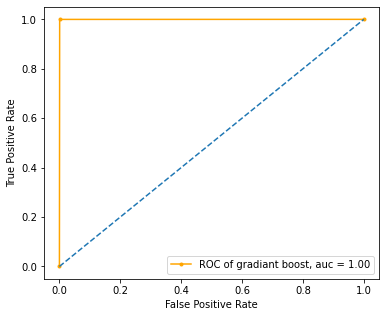

In [89]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred_gbm)
fpr, tpr, _ = roc_curve(y_test, y_pred_gbm)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.',color='orange',label="ROC of gradiant boost, auc = %.2f"% roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[9793   26]
 [ 358 9503]]


Text(33.0, 0.5, 'Actual labels')

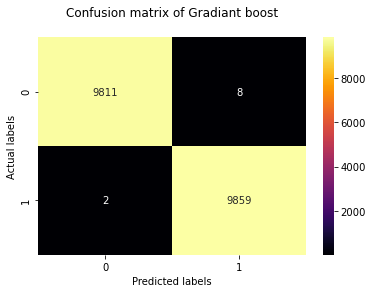

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_gbm), annot = True,fmt='d',cmap="inferno")
print(confusion_matrix(y_test, y_pred_rf))
plt.title('Confusion matrix of Gradiant boost\n')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

In [59]:
AIC_gbm = AIC(y_test,y_pred_gbm,x_train.columns)
print('GBM AIC: ', AIC_gbm)

GBM AIC:  34.33357331188757


<a id="bdt"></a>
### Boosted Decision Tree

The next boosting model we will evaluate AdaBoostRegressor which uses adaptive boosting is an ensemble technique that uses the weighted sum of the various weak learners. The weak learners in this specific example are DecisionTreeRegressor instances a standard decision tree model.[$^{37}$](#37)

<p><img src="https://miro.medium.com/max/1700/0*paPv7vXuq4eBHZY7.png" /></p>

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

params_bdt = {
    'learning_rate': sp_randFloat(),
    'n_estimators' : sp_randInt(100, 1000),
    'random_state': [seed]
}

bdt = RandomizedSearchCV(
    AdaBoostRegressor(DecisionTreeRegressor()),
    param_distributions=params_bdt, 
    cv=5, 
    n_iter=5, 
    n_jobs=-1
)

t1 = time.time()
best_bdt = bdt.fit(x_train, y_train)
t2 = time.time()
y_pred_bdt = best_bdt.predict(x_test)
t3 = time.time()
y_val_bdt = best_bdt.predict(x_train)
t_fit_bdt = t2 - t1
t_pred_bdt = t3 - t2

print('The best parameters across ALL searched params:\n', best_bdt.best_params_)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best parameters across ALL searched params:
 {'learning_rate': 0.9331747670039506, 'n_estimators': 879, 'random_state': 1618}


In [48]:
f1_test_bdt = f1_score(y_test, y_pred_bdt)
f1_train_bdt = f1_score(y_train, y_val_bdt)
f1_delta_bdt = round(f1_test_bdt-f1_train_bdt,5)
print('F1 Score Delta: {}'.format(f1_delta_bdt))

F1 Score Delta: -0.00041


In [49]:
print(classification_report(y_test, y_pred_bdt, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    0.99990   0.99929   0.99959      9819
       Fraud    0.99929   0.99990   0.99959      9861

    accuracy                        0.99959     19680
   macro avg    0.99959   0.99959   0.99959     19680
weighted avg    0.99959   0.99959   0.99959     19680



In [50]:
AIC_bdt = AIC(y_test, y_pred_bdt, x_train.columns)
print('BDT AIC: ', AIC_bdt)

BDT AIC:  35.84111691664033


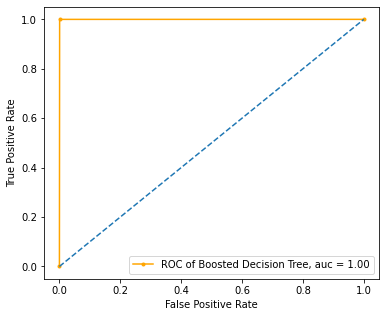

In [62]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred_bdt)
fpr, tpr, _ = roc_curve(y_test, y_pred_bdt)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.',color='orange',label="ROC of Boosted Decision Tree, auc = %.2f"% roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[9812    7]
 [   1 9860]]


Text(33.0, 0.5, 'Actual labels')

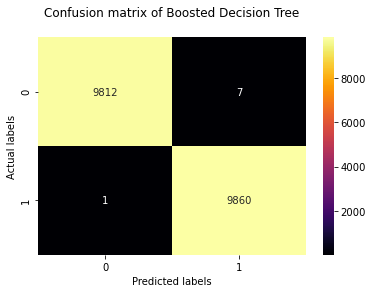

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_bdt), annot = True,fmt='d',cmap="inferno")
print(confusion_matrix(y_test, y_pred_bdt))
plt.title('Confusion matrix of Boosted Decision Tree\n')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

<a id="xgb"></a>
### Extreme Gradient Boost

Our final boosting technique, described as an "efficient and scalable implementation of gradient boosting framwork by Friedman et al." [$^{45}$](#45), eXtreme Gradient Boost (XGB) uses a "more regularized model formalization to control over-fitting, which gives it better performance" [$^{46}$](#46) compared with Gradient Boosting Machine.

In [54]:
import xgboost as xgb

param_xgb = {
    'n_estimators': sp_randInt(150, 1000),
    'learning_rate': sp_randFloat(0.01, 0.6),
    'subsample': sp_randFloat(0.3, 0.9),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': sp_randFloat(0.5, 0.9),
    'min_child_weight': [1, 2, 3, 4],
    'random_state': [seed]
}

xgb = RandomizedSearchCV(
    xgb.XGBClassifier(objective = 'binary:logistic'), 
    param_distributions = param_xgb,
    cv = 5,  
    n_iter = 5, 
    n_jobs = -1
)


t1 = time.time()
best_xgb = xgb.fit(x_train, y_train)
t2 = time.time()
y_pred_xgb = best_xgb.predict(x_test)
t3 = time.time()
y_val_xgb = best_xgb.predict(x_train)
t_fit_xgb = t2 - t1
t_pred_xgb = t3 - t2

print('The best parameters across ALL searched params:\n', best_bdt.best_params_)

The best parameters across ALL searched params:
 {'learning_rate': 0.9331747670039506, 'n_estimators': 879, 'random_state': 1618}


In [55]:
f1_test_xgb = f1_score(y_test, y_pred_xgb)
f1_train_xgb = f1_score(y_train, y_val_xgb)
f1_delta_xgb = round(f1_test_xgb-f1_train_xgb,5)
print('F1 Score Delta: {}'.format(f1_delta_xgb))

F1 Score Delta: -0.00053


In [56]:
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    1.00000   0.99888   0.99944      9819
       Fraud    0.99889   1.00000   0.99944      9861

    accuracy                        0.99944     19680
   macro avg    0.99944   0.99944   0.99944     19680
weighted avg    0.99944   0.99944   0.99944     19680



In [57]:
AIC_xgb = AIC(y_test, y_pred_xgb, x_train.columns)
print('XGB AIC: ', AIC_xgb)

XGB AIC:  35.204209454403255


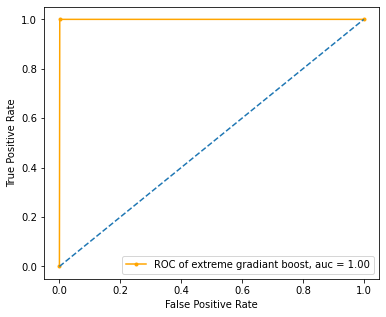

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred_xgb)
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.',color='orange',label="ROC of extreme gradiant boost, auc = %.2f"% roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[9808   11]
 [   0 9861]]


Text(33.0, 0.5, 'Actual labels')

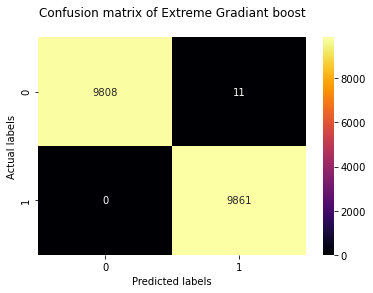

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot = True,fmt='d',cmap="inferno")
print(confusion_matrix(y_test, y_pred_xgb))
plt.title('Confusion matrix of Extreme Gradiant boost\n')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

<a id="forest"></a>
### Random Forest

Random Forest models are in a different "meta-algorithm" class than the previous boosting models called bagging. Bagging is a method where weak learners are created in parallel, as opposed to boosting's sequential approach, and ultimately aggregated to create a kind of average of their individual outputs.[$^{37}$](#37) Random Forests utilize parallel decision trees as shown in the image below. 

<p><img src="https://miro.medium.com/max/1306/0*f_qQPFpdofWGLQqc.png" /></p>

In [77]:
from sklearn.ensemble import RandomForestClassifier

params_rf = { 
    'n_estimators':  sp_randInt(100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': sp_randInt(4, 10),
    'bootstrap': [True, False],
    'random_state': [seed]
}

rf = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=params_rf, 
    cv=5, 
    n_iter=5, 
    n_jobs=-1
)

t1 = time.time()
best_rf = rf.fit(x_train, y_train)
t2 = time.time()
y_pred_rf = best_rf.predict(x_test)
t3 = time.time()
y_val_rf = best_rf.predict(x_train)
t_fit_rf = t2 - t1
t_pred_rf = t3 - t2

print('The best parameters across ALL searched params:\n', best_rf.best_params_)

The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 146, 'random_state': 1618}


In [78]:
f1_test_rf = f1_score(y_test, y_pred_rf)
f1_train_rf = f1_score(y_train, y_val_rf)
f1_delta_rf = round(f1_test_rf-f1_train_rf,5)
print('F1 Score Delta: {}'.format(f1_delta_rf))

F1 Score Delta: -0.00125


In [79]:
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    0.96473   0.99735   0.98077      9819
       Fraud    0.99727   0.96370   0.98020      9861

    accuracy                        0.98049     19680
   macro avg    0.98100   0.98052   0.98048     19680
weighted avg    0.98104   0.98049   0.98048     19680



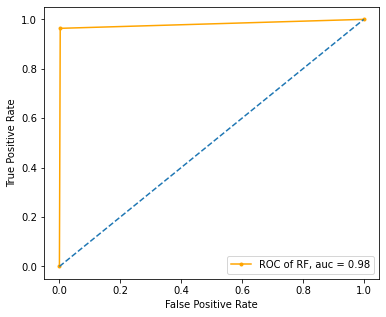

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.',color='orange',label="ROC of RF, auc = %.2f"% roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[9793   26]
 [ 358 9503]]


Text(33.0, 0.5, 'Actual labels')

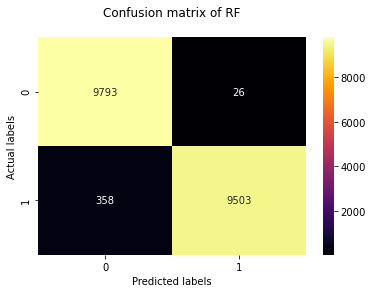

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True,fmt='d',cmap="inferno")
print(confusion_matrix(y_test, y_pred_rf))
plt.title('Confusion matrix of RF\n')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

In [80]:
AIC_rf = AIC(y_test, y_pred_rf, x_train.columns)
print('RF AIC: ', AIC_rf)

RF AIC:  28.098714894824546


<a id="nn"></a>
### Neural Network
Scikit-learn's implementation of an artificial neural network is the MLPClassifier. Artifical neural networks, often referred to simply as neural networks, are "a wide class of flexible nonlinear regression and discriminant models, data reduction models, and nonlinear dynamic systems" inspired by biological neural networks. Typically represented  as layers of nodes connected to one another like neurons connected through synapses. Each node representing some simple mathematical process of its input. The layers are commonly designated as the input layer (first layer), output layer (last layer), and hidden layer(s) (inner layer(s)). Most neural networks are fully connected from one layer to another with particular weights applied to the connections. [$^{39}$](#39) [$^{40}$](#40)

<p><img src="https://www.gyansetu.in/wp-content/uploads/2020/02/Neural-Network-in-AI-min.png" /></p>

Neural networks are amongst some of the most complex models in use at scale across industries. This complexity of course comes at a cost according to Geman et al. however recent papers have been investigating the U-shaped test error curve and refute this claim.[$^{41}$](#41) [$^{42}$](#42) Whether or not the bias-variance tradeoff is present in a neural network, one thing is certain, computational resources are required to execute and this can significantly increase the time for delivering a prediction. Our use case of credit card fraud may prohibit the use of this model but for the sake of evaluating the accuracy and its comparison to the previous models we will proceed.

<p><img src="https://www.bradyneal.com/img/bias-variance/fortmann-roe-bias-variance.png" /></p>

In [64]:
from sklearn.neural_network import MLPClassifier
params_nn = { 
    'hidden_layer_sizes':  [(sp_randInt.rvs(10,200,1),
                             sp_randInt.rvs(10,200,1),),
                            (sp_randInt.rvs(10,200,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': sp_randFloat(0.0001, 0.05),
    'learning_rate': ['constant','adaptive'],
    'random_state': [seed]
}

nn = RandomizedSearchCV(
    MLPClassifier(),
    param_distributions=params_nn, 
    cv=5, 
    n_iter=5, 
    n_jobs=-1
)


t1 = time.time()
best_nn = nn.fit(x_train,y_train)
t2 = time.time()
y_pred_nn = best_nn.predict(x_test)
t3 = time.time()
y_val_nn = best_nn.predict(x_train)
t_fit_nn = t2 - t1
t_pred_nn = t3 - t2

print('The best parameters across ALL searched params:\n', best_nn.best_params_)

The best parameters across ALL searched params:
 {'activation': 'relu', 'alpha': 0.01328057110646253, 'hidden_layer_sizes': (88, 68), 'learning_rate': 'constant', 'random_state': 1618, 'solver': 'lbfgs'}


In [65]:
f1_test_nn = f1_score(y_test, y_pred_nn)
f1_train_nn = f1_score(y_train, y_val_nn)
f1_delta_nn = round(f1_test_nn-f1_train_nn,5)
print('F1 Score Delta: {}'.format(f1_delta_nn))

F1 Score Delta: -0.00111


In [66]:
print(classification_report(y_test, y_pred_nn, target_names=['Normal', 'Fraud'], digits=5))

              precision    recall  f1-score   support

      Normal    1.00000   0.99776   0.99888      9819
       Fraud    0.99777   1.00000   0.99889      9861

    accuracy                        0.99888     19680
   macro avg    0.99889   0.99888   0.99888     19680
weighted avg    0.99888   0.99888   0.99888     19680



In [67]:
AIC_nn = AIC(y_test, y_pred_nn, x_train.columns)
print('NN AIC: ', AIC_nn)

NN AIC:  33.81791509328337


[[9797   22]
 [   0 9861]]


Text(33.0, 0.5, 'Actual labels')

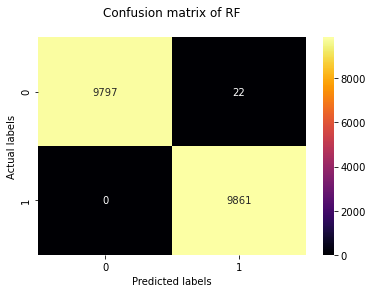

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot = True,fmt='d',cmap="inferno")
print(confusion_matrix(y_test, y_pred_nn))
plt.title('Confusion matrix of RF\n')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

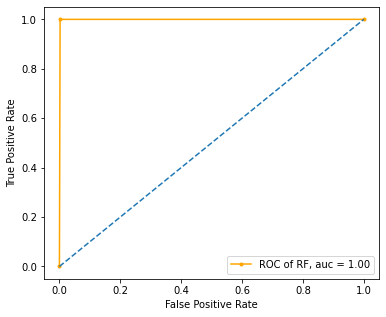

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred_nn)
fpr, tpr, _ = roc_curve(y_test, y_pred_nn)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.',color='orange',label="ROC of RF, auc = %.2f"% roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

<a id="outro"></a>
## Conclusions
After evaluating all of our models and exclusively looking at their F1 scores, the **Boosted Decision Tree**, which leveraged an adaptive boosting technique performed the best. Interestingly if we were to use traditional statistics for evaluating model goodness of fit the **Logistic Regression** would be selected based on it minimizing the AIC. The LR model was also the only one that did not show signs of overfitting as seen with an F1 delta > 0 although the XGB model did have the smallest measure of overfitting.

In [ ]:
def bold(var):
    s = '\033[1m' + str(round(var,5)) + '\033[0m'
    return s

lr_str = 'Logistic Regression\nF1 score: {:.5f}\tF1 delta: {}\tAIC: {}\n'
gbm_str = 'Gradient Boosting Machine\nF1 score: {:.5f}\tF1 delta: {:.5f}\tAIC: {:.5f}\n'
bdt_str = 'Boosted Decision Tree\nF1 score: {}\tF1 delta: {}\tAIC: {:.5f}\n'
xgb_str = 'Extreme Gradient Boost\nF1 score: {:.5f}\tF1 delta: {}\tAIC: {:.5f}\n'
rf_str = 'Random Forest\nF1 score: {:.5f}\tF1 delta: {:.5f}\tAIC: {:.5f}\n'
nn_str = 'Neural Network\nF1 score: {:.5f}\tF1 delta: {:.5f}\tAIC: {:.5f}\n'

print(lr_str.format(f1_test_lr, bold(f1_delta_lr), bold(AIC_lr)))
print(gbm_str.format(f1_test_gbm, f1_delta_gbm, AIC_gbm))
print(bdt_str.format(bold(f1_test_bdt), f1_delta_bdt, AIC_bdt))
print(xgb_str.format(f1_test_xgb, f1_delta_xgb, AIC_xgb))
print(rf_str.format(f1_test_rf, f1_delta_rf, AIC_rf))
print(nn_str.format(f1_test_nn, f1_delta_nn, AIC_nn))

Given that the goal of our project was to determine the most performative model it is worthwhile for us to assess the speed of the models for both fitting and predicting. We should also note here that this dataset contains just two days of transactions and the true population size is unknown however we can assume that the population is considerably larger. This is important to know because some hyperparameter changes would likely be required for implementation, specifically the LR **solver** and **n_jobs** parameters. As noted in the Scikit-learn documentation _"For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones."_ 

In [ ]:
fit_times = [t_fit_lr, t_fit_gbm, t_fit_bdt, t_fit_xgb, t_fit_rf, t_fit_nn]
pred_times = [t_pred_lr, t_pred_gbm, t_pred_bdt, t_pred_xgb, t_pred_rf, t_pred_nn]
tick_label=['LR','GBM','BDT','XGB','RF','NN']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5));
axes[0].set_title('Time to Fit');
axes[0].bar(x=[l for l in range(6)], height=fit_times, width=0.8, tick_label=tick_label)
for i, v in enumerate(fit_times):
    axes[0].annotate(str(round(v,2)),(i, v), ha='center', va='bottom')
axes[1].set_title('Time to Predict');
axes[1].bar(x=[l for l in range(6)], height=pred_times, width=0.8, tick_label=tick_label)
for i, v in enumerate(pred_times):
    axes[1].annotate(str(round(v,4)),(i, v), ha='center', va='bottom')
plt.show();

While not in scope for our discussions there is a whole field of study around distributed computing and the architecture behind deploying ML solutions at scale that could shift practitioners decisions on the optimal solution.[$^{43}$](#43) Based on our criterion for model comparison and evaluation the **Logistic Regression** has been identified as the best solution for our credit card fraud detection problem. Lets dive a bit deeper into this solution and take a look into the effects quantification and feature importance. 

In [ ]:
final_model = LogisticRegression(
    C=0.35957637139353915, 
    penalty='l2', 
    solver='lbfgs',
    random_state=seed
).fit(x_train,y_train)
coefs = pd.DataFrame(final_model.coef_,columns=x_train.columns, index=['coefs'])
odds_ratios = pd.DataFrame(np.exp(final_model.coef_),columns=x_train.columns, index=['odds_ratio']) 
pd.concat([coefs,odds_ratios])

While the principal components are unknown due to the anonymization process behind PCA we can see from the coefficients that the log-odds of a transaction being fraudulent is **1.040989** for a transaction having 1 unit increase of `V4` holding all other variables constant. Another way of describing this relationship is with odds ratio in which case we would state 1 unit increase of `V4` increases the odds of a transaction being fraudulent by **2.83** times. While odds ratio descriptions are significantly easier to understand than log-odds, this is still a bit ambiguous when compared to linear regression interpretations. Marginal effects are an alternative metric that describe the impact of the predictor on the outcome variable with the Average Marginal Effect (AME) representing the impact on the probability of the outcome.[$^{44}$](#44) Using the marginal effect approach we can interpret 1 unit increase of `V4` increasing the probability of fraud by **73.52%**.

In [ ]:
from sklearn.inspection import plot_partial_dependence, partial_dependence

plot_partial_dependence(final_model, x_train, ['V4'])
V4_AME = round(np.mean(partial_dependence(final_model, x_train, [4])[0]),4)

print('Average Marginal Effect of V4: {}'.format(V4_AME))

We wrap up the notebook with a quick review of feature importance. Scikit-learn's LogisticRegression model does not directly output feature importance like the ExtraTreesClassifier, RandomForestClassifier, or RecursiveFeatureElimination methods, however, one can calculate the relative feature importance as shown below. This approach uses the relative weights of the coefficients produced by the model. The top 5 important features are `V14, V12, V4, V10, V17` which unsurprisingly are also the 5 variables with the largest separation between the fraud and normal distributions as seen in the [histogram/KDE plots](#kde) from the [analyze relationships - correlation section](#relate). 

In [ ]:
feature_importance = abs(final_model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .75

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(x_train.columns)[sorted_idx])
ax.set_title('Relative Feature Importance')
plt.show();

#### <a id="citations"></a>
## Citations

<a id=1></a>$^{1}$Credit Card Fraud. 15 June 2016, www.fbi.gov/scams-and-safety/common-scams-and-crimes/credit-card-fraud. 

<a id=2></a>$^{2}$Federal Trade Commission . (2019). Consumer Sentinel Network data book for January–December 2019. Washington, DC. Retrieved from https://www.ftc.gov/system/files/documents/reports/consumer-sentinel-network-data-book-2019/consumer_sentinel_network_data_book_2019.pdf

<a id=3></a>$^{3}$"The Nilson Report Newsletter Archive", The Nilson Report, November 2019, https://nilsonreport.com/upload/content_promo/The_Nilson_Report_Issue_1164.pdf.

<a id=4></a>$^{4}$Sobers, Rob. “107 Must-Know Data Breach Statistics for 2020.” Varonis, 24 Sept. 2020, www.varonis.com/blog/data-breach-statistics/

<a id=5></a>$^{5}$Bourke, Daniel. “A Gentle Introduction to Exploratory Data Analysis.” Medium, Towards Data Science, 13 Feb. 2019, towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184. 

<a id=6></a>$^{6}$[Data structures for statistical computing in python](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf), McKinney, Proceedings of the 9th Python in Science Conference, Volume 445, 2010.

<a id=7></a>$^{7}$Kang H. The prevention and handling of the missing data. Korean J Anesthesiol. 2013;64(5):402-406. doi: [10.4097/kjae.2013.64.5.402](https://doi.org/10.4097/kjae.2013.64.5.402)

<a id=8></a>$^{8}$Wikipedia contributors. "Feature scaling." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 28 Oct. 2020. Web. 1 Nov. 2020.

<a id=9></a>$^{9}$Roy, Baijayanta. “All about Feature Scaling.” Medium, Towards Data Science, 7 Apr. 2020, towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35. 

<a id=10></a>$^{10}$J. D. Hunter, "Matplotlib: A 2D Graphics Environment," in Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, May-June 2007, doi: [10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55)

<a id=11></a>$^{11}$[Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

<a id=12></a>$^{12}$Muhammad Atif Tahir, Josef Kittler, Fei Yan,
Inverse random under sampling for class imbalance problem and its application to multi-label classification, Pattern Recognition, Volume 45, Issue 10, 2012, Pages 3738-3750,ISSN 0031-3203, doi: [10.1016/j.patcog.2012.03.014](https://doi.org/10.1016/j.patcog.2012.03.014)

<a id=13></a>$^{13}$Dataman, Dr. “Using Under-Sampling Techniques for Extremely Imbalanced Data.” Medium, Medium, 27 Oct. 2020, medium.com/@Dataman.ai/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8. 

<a id=14></a>$^{14}$Cohen, Ira. “Outliers Explained: a Quick Guide to the Different Types of Outliers.” Medium, Towards Data Science, 8 Nov. 2018, towardsdatascience.com/outliers-analysis-a-quick-guide-to-the-different-types-of-outliers-e41de37e6bf6. 

<a id=15></a>$^{15}$Frost, Jim. “Guidelines for Removing and Handling Outliers in Data.” Statistics By Jim, 6 June 2020, statisticsbyjim.com/basics/remove-outliers/. 

<a id=16></a>$^{16}$Nyitrai, Tamás, and Miklós Virág. “The Effects of Handling Outliers on the Performance of Bankruptcy Prediction Models.” Socio-Economic Planning Sciences, vol. 67, 2019, pp. 34–42., doi:[10.1016/j.seps.2018.08.004](https://doi.org/10.1016/j.seps.2018.08.004) 

<a id=17></a>$^{17}$Bhat, Naresh. “Outlier!!! The Silent Killer.” Kaggle, Kaggle, 26 Oct. 2020, www.kaggle.com/nareshbhat/outlier-the-silent-killer. 


<a id=18></a>$^{18}$Franzese, Monica, and Antonella Iuliano. “Correlation Analysis.” Encyclopedia of Bioinformatics and Computational Biology, 2019, pp. 706–721., doi:[10.1016/b978-0-12-809633-8.20358-0](https://doi.org/10.1016/b978-0-12-809633-8.20358-0) 

<a id=19></a>$^{19}$Wikipedia contributors. "Pearson correlation coefficient." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 31 Oct. 2020. Web. 2 Nov. 2020.

<a id=20></a>$^{20}$Waskom, Michael et al. “Mwaskom/Seaborn.” 0.11.0, Zenodo, Sept. 2020, doi.org/10.5281/zenodo.592845. 

<a id=21></a>$^{21}$Mitchell, Tom M. “Machine Learning.” Amazon, McGraw Hill, 2017, docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html. 

<a id=22></a>$^{22}$Wikipedia contributors. "Sensitivity and specificity." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 20 Oct. 2020. Web. 2 Nov. 2020.

<a id=23></a>$^{23}$Wikipedia contributors. "F-score." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 22 Oct. 2020. Web. 2 Nov. 2020.

<a id=24></a>$^{24}$Pozzolo, Andrea Dal, et al. “Learned Lessons in Credit Card Fraud Detection from a Practitioner Perspective.” Expert Systems with Applications, vol. 41, no. 10, 2014, pp. 4915–4928., doi:[10.1016/j.eswa.2014.02.026](https://doi.org/10.1016/j.eswa.2014.02.026) 

<a id=25></a>$^{25}$Chawla, N. V., et al. “SMOTE: Synthetic Minority Over-Sampling Technique.” Journal of Artificial Intelligence Research, vol. 16, 2002, pp. 321–357., doi:[10.1613/jair.953](https://doi.org/10.1613/jair.953) 

<a id=26></a>$^{26}$Zornoza, Jaime. “Logistic Regression Explained.” Medium, Towards Data Science, 13 Oct. 2020, towardsdatascience.com/logistic-regression-explained-9ee73cede081. 

<a id=27></a>$^{27}$Chao-Ying Joanne Peng, Kuk Lida Lee & Gary M. Ingersoll (2002) An Introduction to Logistic Regression Analysis and Reporting, The Journal of Educational Research, 96:1, 3-14, DOI: [10.1080/00220670209598786](https://doi.org/10.1080/00220670209598786) 

<a id=28></a>$^{28}$Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: [0.1038/s41586-020-2649-2](https://doi.org/0.1038/s41586-020-2649-2). ([Publisher link](https://www.nature.com/articles/s41586-020-2649-2))

<a id=29></a>$^{29}$Powers, David M W (2011). "Evaluation: From Precision, Recall and F-Measure to ROC, Informedness, Markedness & Correlation". Journal of Machine Learning Technologies. 2 (1): 37–63. S2CID 55767944

<a id=30></a>$^{30}$Choi, Tsan-Ming, et al. “A Hybrid SARIMA Wavelet Transform Method for Sales Forecasting.” Decision Support Systems, vol. 51, no. 1, 2011, pp. 130–140., doi:[10.1016/j.dss.2010.12.002](https://doi.org/10.1016/j.dss.2010.12.002) 

<a id=31></a>$^{31}$Hawkins, Douglas M. “The Problem of Overfitting.” Journal of Chemical Information and Computer Sciences, vol. 44, no. 1, 2004, pp. 1–12., doi:[10.1021/ci0342472](https://doi.org/10.1021/ci0342472)

<a id=32></a>$^{32}$Seabold, Skipper, and Josef Perktold. “[statsmodels: Econometric and statistical modeling with python.](http://conference.scipy.org/proceedings/scipy2010/pdfs/seabold.pdf)” Proceedings of the 9th Python in Science Conference. 2010.

<a id=33></a>$^{33}$Jordan, Jeremy. “Hyperparameter Tuning for Machine Learning Models.” Jeremy Jordan, Jeremy Jordan, 5 Dec. 2018, www.jeremyjordan.me/hyperparameter-tuning/. 

<a id=34></a>$^{34}$Bergstra, James, and Yoshua Bengio. “Random Search for Hyper-Parameter Optimization.” The Journal of Machine Learning Research, 1 Feb. 2012, [dl.acm.org/doi/abs/10.5555/2188385.2188395](https://dl.acm.org/doi/abs/10.5555/2188385.2188395). 

<a id=35></a>$^{35}$DeFilippi, Robert R.F. “Boosting, Bagging, and Stacking - Ensemble Methods with Sklearn and Mlens.” Medium, Medium, 4 Aug. 2018, medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de. 

<a id=36></a>$^{36}$T. M. Khoshgoftaar, J. Van Hulse and A. Napolitano, "Comparing Boosting and Bagging Techniques With Noisy and Imbalanced Data," in IEEE Transactions on Systems, Man, and Cybernetics - Part A: Systems and Humans, vol. 41, no. 3, pp. 552-568, May 2011, doi: 10.1109/TSMCA.2010.2084081.

<a id=37></a>$^{37}$Rocca, Joseph. “Ensemble Methods: Bagging, Boosting and Stacking.” Medium, Towards Data Science, 5 May 2019, towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205. 

<a id=38></a>$^{38}$McDonald, Conor. “Machine Learning Fundamentals (I): Cost Functions and Gradient Descent.” Medium, Towards Data Science, 5 Nov. 2018, towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220. 

<a id=39></a>$^{39}$Sarle, Warren S. "Neural Networks and Statistical Models". SAS Institute Inc., 1994, http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1066.9086&rep=rep1&type=pdf

<a id=40></a>$^{40}$Marr, Bernard. “What Are Artificial Neural Networks - A Simple Explanation For Absolutely Anyone.” Forbes, Forbes Magazine, 24 Sept. 2018, www.forbes.com/sites/bernardmarr/2018/09/24/what-are-artificial-neural-networks-a-simple-explanation-for-absolutely-anyone/?sh=39cd8be51245. 

<a id=41></a>$^{41}$Geman, Stuart, et al. “Neural Networks and the Bias/Variance Dilemma.” Neural Computation, vol. 4, no. 1, 1992, pp. 1–58., doi:[10.1162/neco.1992.4.1.1](https://doi.org/10.1162/neco.1992.4.1.1). 

<a id=42></a>$^{42}$Neal, Brady, et al. “A Modern Take on the Bias-Variance Tradeoff in Neural Networks.” ArXiv.org, 18 Dec. 2019, arxiv.org/abs/1810.08591. 

<a id=43></a>$^{43}$Buyya, Rajkumar, et al. “Principles of Parallel and Distributed Computing.” Mastering Cloud Computing, Morgan Kaufmann, 12 Apr. 2013, www.sciencedirect.com/science/article/pii/B9780124114548000024. 

<a id=44></a>$^{44}$Raoniar, Rahul. “Fitting MLR and Binary Logistic Regression Using Python (Research-Oriented Modeling &amp;...” Medium, Towards Data Science, 9 Oct. 2020, towardsdatascience.com/fitting-mlr-and-binary-logistic-regression-using-python-research-oriented-modeling-dcc22f1f0edf. 

<a id=45></a>$^{45}$Chen, Tianqi, and Tong He. “Xgboost: EXtreme Gradient Boosting.” The Comprehensive R Archive Network, 2 Sept. 2020, cran.r-project.org/web/packages/xgboost/vignettes/xgboost.pdf. 

<a id=46></a>$^{46}$Chen, Tianqi. “What Is the Difference between the R Gbm (Gradient Boosting Machine) and Xgboost (Extreme Gradient Boosting)?” Quora, 3 Sept. 2015, www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting/answer/Tianqi-Chen-1?srid=8Ze. 

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. [Calibrating Probability with Undersampling for Unbalanced Classification](https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification). In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea [Adaptive Machine learning for credit card fraud detection](http://di.ulb.ac.be/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf) ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. [Scarff: a scalable framework for streaming credit card fraud detection with Spark](https://www.researchgate.net/publication/319616537_SCARFF_a_Scalable_Framework_for_Streaming_Credit_Card_Fraud_Detection_with_Spark), Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. [Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization](https://www.researchgate.net/publication/332180999_Deep-Learning_Domain_Adaptation_Techniques_for_Credit_Cards_Fraud_Detection), International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi [Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection](https://www.researchgate.net/publication/332180999_Deep-Learning_Domain_Adaptation_Techniques_for_Credit_Cards_Fraud_Detection), INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi [Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection](https://www.researchgate.net/publication/333143698_Combining_Unsupervised_and_Supervised_Learning_in_Credit_Card_Fraud_Detection) Information Sciences, 2019

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. [Credit card fraud detection: a realistic modeling and a novel learning strategy](https://www.researchgate.net/publication/319867396_Credit_Card_Fraud_Detection_A_Realistic_Modeling_and_a_Novel_Learning_Strategy), IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE